In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from scipy.signal import butter, filtfilt

def seed_assign(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


In [2]:
data_path = '/data2/spike_sorting/neuropixels_choi'
filename = ["/set1/20141202_all_es", "/set2/20150924_1_e", "/set3/20150601_all_s", "/set4/20150924_1_GT"]

index = 2
ground_truth_path = data_path+filename[index]+'_gtTimes.mat'

width = 1_500_000
max_iter = 5
n_channel = 129
n_unit = 7 if index != 2 else 8 # set2는 예외적으로 unit 8개다.
frequency = 25_000
my_seed = 42
seed_assign(my_seed)

sample_num_limit = 3_125_000


In [3]:
ground_truth_path = data_path+filename[index]+'_gtTimes.mat'

mat1 = io.loadmat(ground_truth_path)
spike_times_int_all_units = []
for i in range(n_unit):
    temp = mat1['gtTimes'][0][i][:,0]
    temp = temp[temp < sample_num_limit]
    spike_times_int_all_units.append(temp)
    print('unit', i, '스파이크 튄 gttime', temp.shape)

spike_chans_int_all_units = []
for i in range(n_unit):
    spike_chans_int_all_units.append(mat1['gtChans'][0][i][:,0])
    print('unit', i,'연관 ch', mat1['gtChans'][0][i][:,0].shape)
    
print('유닛 개수', mat1['gtTimes'][0].shape)

unit 0 스파이크 튄 gttime (2,)
unit 1 스파이크 튄 gttime (9,)
unit 2 스파이크 튄 gttime (34,)
unit 3 스파이크 튄 gttime (0,)
unit 4 스파이크 튄 gttime (2,)
unit 5 스파이크 튄 gttime (31,)
unit 6 스파이크 튄 gttime (37,)
unit 7 스파이크 튄 gttime (279,)
unit 0 연관 ch (12,)
unit 1 연관 ch (9,)
unit 2 연관 ch (11,)
unit 3 연관 ch (12,)
unit 4 연관 ch (13,)
unit 5 연관 ch (12,)
unit 6 연관 ch (14,)
unit 7 연관 ch (11,)
유닛 개수 (8,)


In [4]:
# np.save(f"{data_path}{filename[index]}_merged_{sample_num_limit}_limit.npy", merged_waveform)
# np load
merged_waveform = np.load(f"{data_path}{filename[index]}_merged_{sample_num_limit}_limit.npy")

# Cropping Spike for AE

In [5]:
# spike_length = 50
# max_slope_early_offset = 10
# max_slope_late_offset = 25

# spike_crop_early_offset = 10

spike_length = 50
max_slope_early_offset = 0
max_slope_late_offset = 1

spike_crop_early_offset = 10

In [6]:
spike_chans_int_all_units

[array([28, 27, 26, 24, 23, 22, 60, 55, 56, 57, 58, 59], dtype=uint8),
 array([ 77,  68, 100,  79,  78,  67,  66,  99, 111], dtype=uint8),
 array([29, 30, 17, 18, 19, 62, 63, 64, 50, 51, 52], dtype=uint8),
 array([ 94,  95,  96,  83,  84, 125, 126, 127, 128, 114, 115, 116],
       dtype=uint8),
 array([ 75,  76,  77,  69,  70,  74, 106, 107, 108, 109, 101, 102, 103],
       dtype=uint8),
 array([ 75,  76,  77,  68,  69,  70, 107, 108, 109, 100, 101, 102],
       dtype=uint8),
 array([ 76,  77,  68,  69,  70, 108, 109, 100, 101, 102,  78,  67,  99,
        111], dtype=uint8),
 array([ 92,  86,  87,  88,  90,  91, 124, 119, 120, 122, 123], dtype=uint8)]

In [7]:
print('merged_waveform shape', merged_waveform.shape)
print(len(spike_chans_int_all_units))
print(len(spike_times_int_all_units))
# print(spike_chans_int_all_units[0])
# print(spike_times_int_all_units[0])

merged_waveform shape (129, 3125000)
8
8


In [8]:
diff_waveform = np.diff(merged_waveform, axis=1)

In [9]:
spike_this_dataset = []
label_this_dataset = []
for unit in range(n_unit):
    print('unit', unit)
    related_ch = spike_chans_int_all_units[unit]
    for i in range(len(spike_times_int_all_units[unit])):
        t = spike_times_int_all_units[unit][i]
        ch_winner_determinant = -999999999
        ch_winner = -1
        max_slope_index_winner = -1
        for ch in related_ch:
            max_slope_index = t + np.argmax(diff_waveform[ch, t-max_slope_early_offset : t+max_slope_late_offset]) - max_slope_early_offset
            now_spike = merged_waveform[ch,max_slope_index - spike_crop_early_offset : max_slope_index - spike_crop_early_offset + spike_length]
            if ch_winner_determinant < diff_waveform[ch, max_slope_index]:
                ch_winner_determinant = diff_waveform[ch, max_slope_index]
                now_spike_winner = now_spike
                max_slope_index_winner = max_slope_index
                ch_winner = ch
        if ch_winner == -1:
            assert False
        spike_this_dataset.append(now_spike_winner)
        label_this_dataset.append([unit, ch_winner, max_slope_index_winner - spike_crop_early_offset, max_slope_index_winner - spike_crop_early_offset + spike_length, t, max_slope_index_winner, ch_winner_determinant])

spike_this_dataset = np.array(spike_this_dataset)
label_this_dataset = np.array(label_this_dataset)

spike_this_dataset = torch.tensor(spike_this_dataset)
label_this_dataset = torch.tensor(label_this_dataset)

data_save_path = f"{data_path}{filename[index]}_merged_{sample_num_limit}_limit_autoencoder_data.pt"
label_save_path = f"{data_path}{filename[index]}_merged_{sample_num_limit}_limit_autoencoder_label.pt"


torch.save(spike_this_dataset, data_save_path)
torch.save(label_this_dataset, label_save_path)

print(data_save_path)
print(label_save_path)

print('spike_this_dataset', spike_this_dataset.shape)
print('label_this_dataset', label_this_dataset.shape)

unit 0
unit 1
unit 2
unit 3
unit 4
unit 5
unit 6
unit 7
/data2/spike_sorting/neuropixels_choi/set3/20150601_all_s_merged_3125000_limit_autoencoder_data.pt
/data2/spike_sorting/neuropixels_choi/set3/20150601_all_s_merged_3125000_limit_autoencoder_label.pt
spike_this_dataset torch.Size([394, 50])
label_this_dataset torch.Size([394, 7])


unit 6, ch 100, start 482980, end 483030, gt 482990, max_slope_index 482990, ch_winner_determinant 0.8210162766510594


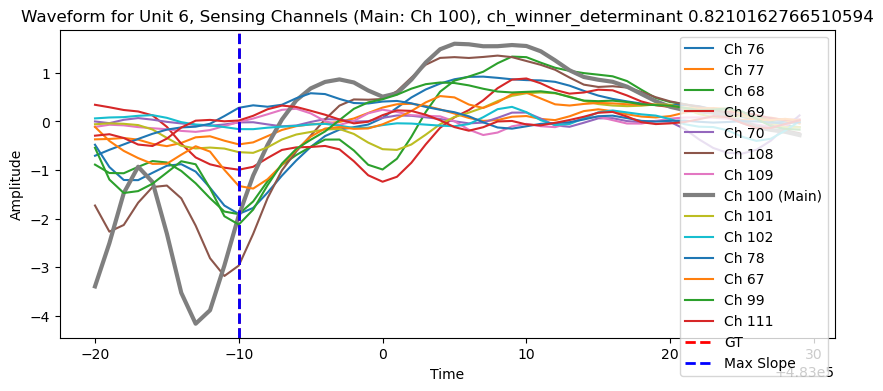

unit 6, ch 100, start 482972, end 483022, gt 482982, max_slope_index 482982, ch_winner_determinant 0.5435173435571703


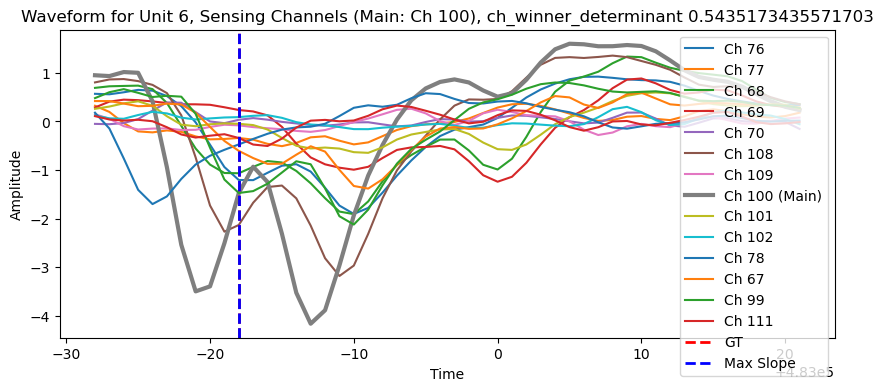

unit 6, ch 100, start 482529, end 482579, gt 482539, max_slope_index 482539, ch_winner_determinant 0.7608190824829084


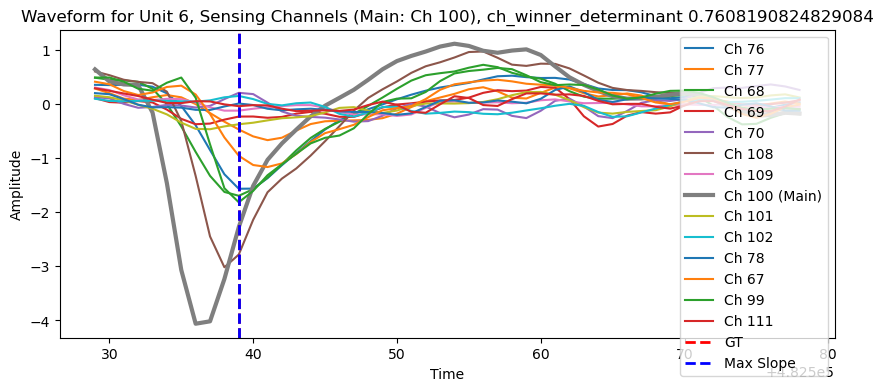

unit 6, ch 100, start 482324, end 482374, gt 482334, max_slope_index 482334, ch_winner_determinant 0.6567944455709018


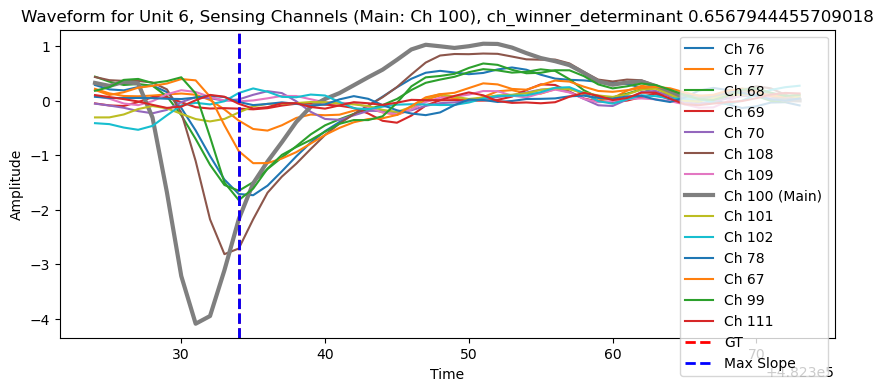

unit 6, ch 100, start 485025, end 485075, gt 485035, max_slope_index 485035, ch_winner_determinant 0.5965432128073744


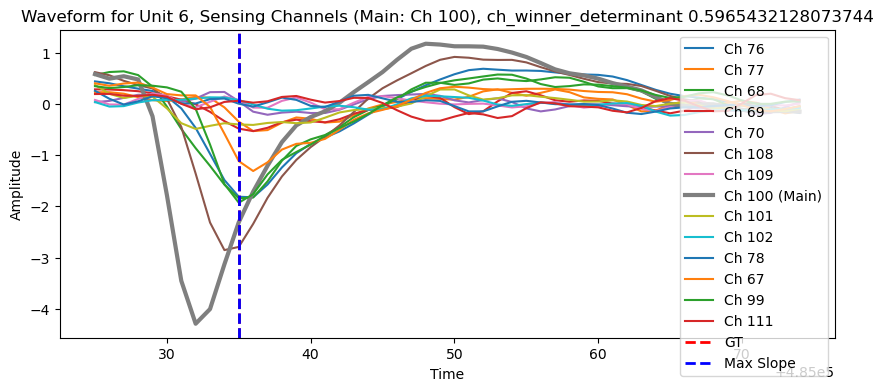

unit 6, ch 100, start 485240, end 485290, gt 485250, max_slope_index 485250, ch_winner_determinant 0.6367488732097732


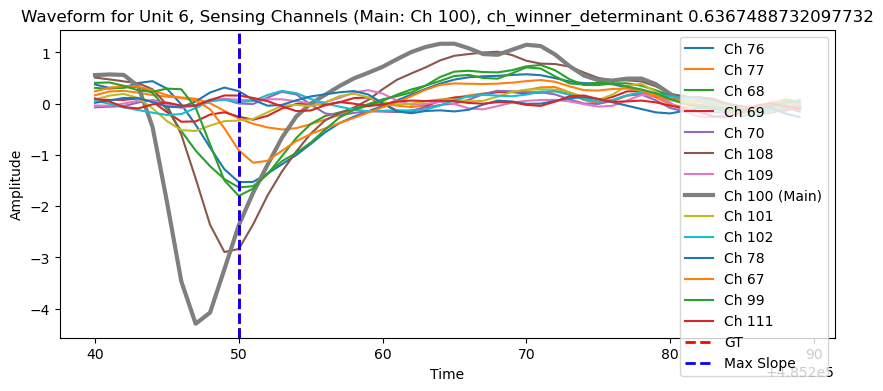

unit 6, ch 100, start 525559, end 525609, gt 525569, max_slope_index 525569, ch_winner_determinant 0.6812926959409289


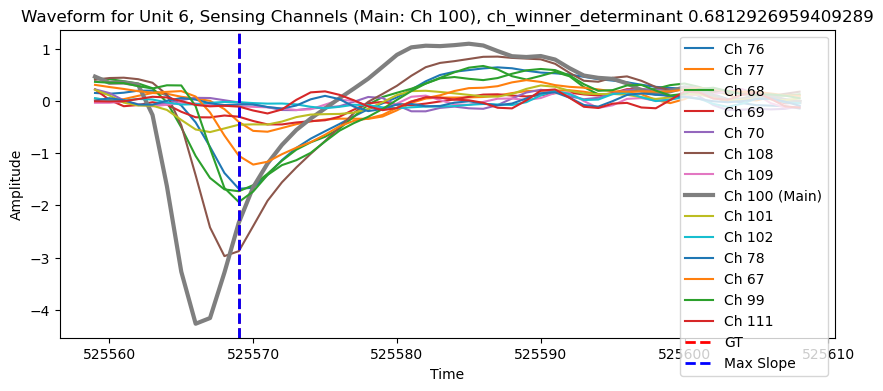

unit 6, ch 100, start 525960, end 526010, gt 525970, max_slope_index 525970, ch_winner_determinant 0.6867996513141659


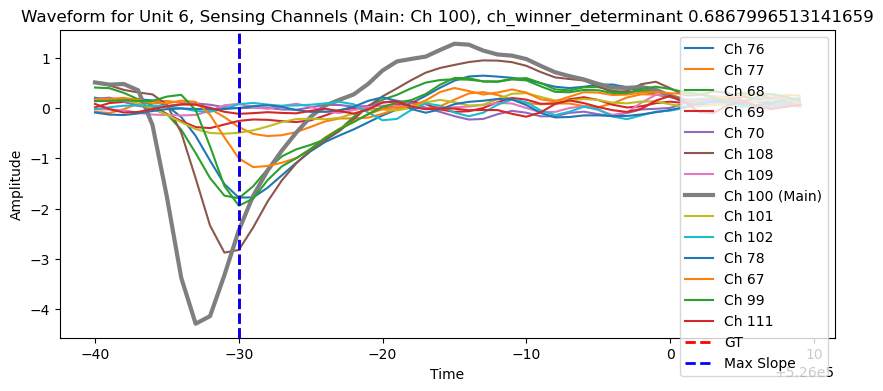

unit 6, ch 100, start 526360, end 526410, gt 526370, max_slope_index 526370, ch_winner_determinant 0.7248277299708192


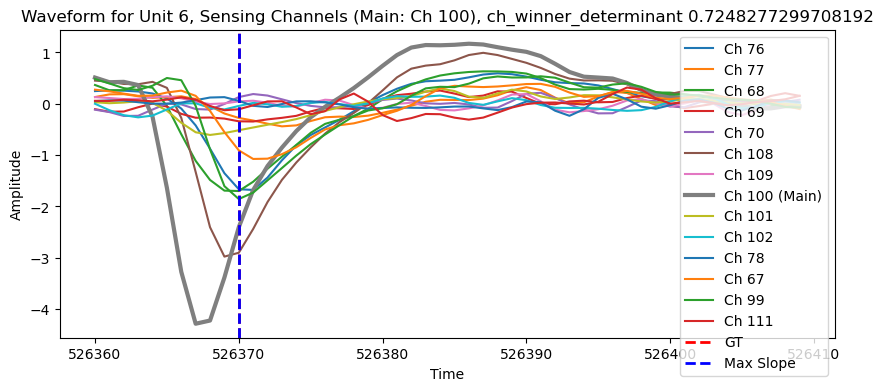

unit 6, ch 100, start 915435, end 915485, gt 915445, max_slope_index 915445, ch_winner_determinant 0.7454309062325617


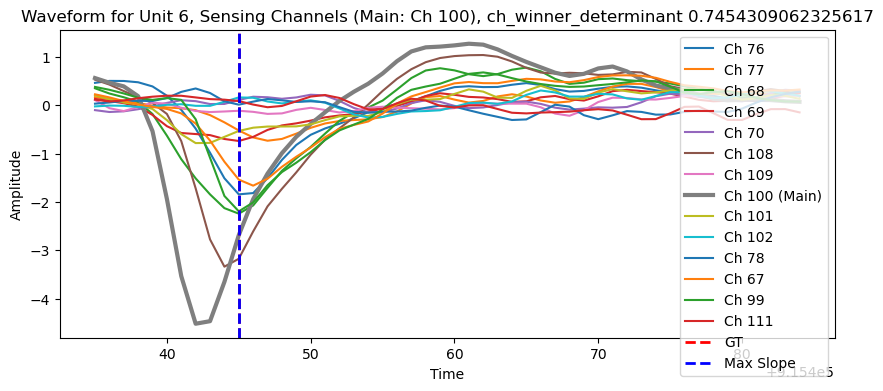

In [10]:
import matplotlib.pyplot as plt

look_unit = 6
max_picture = 10
count = 0
for i in range(label_this_dataset.shape[0]):
    unit, ch, start, end, gt, max_slope_index = map(int, label_this_dataset[i][:6])
    ch_winner_determinant = label_this_dataset[i][6]
    if unit == look_unit:
        count += 1
        print(f'unit {unit}, ch {ch}, start {start}, end {end}, gt {gt}, max_slope_index {max_slope_index}, ch_winner_determinant {ch_winner_determinant}')

        related_ch = spike_chans_int_all_units[unit]

        
        plt.figure(figsize=(10, 4))
        
        for related in related_ch:
            if related == ch:
                plt.plot(range(start, end), merged_waveform[related, start:end], label=f'Ch {related} (Main)', linewidth=3.0)
            else:
                plt.plot(range(start, end), merged_waveform[related, start:end], label=f'Ch {related}', linewidth=1.5)
        
        # Ground Truth (GT) 위치에 수직선
        plt.axvline(x=gt, color='r', linestyle='--', label='GT', linewidth=2.0)
        
        # 최대 기울기 인덱스 위치에 수직선
        plt.axvline(x=max_slope_index, color='b', linestyle='--', label='Max Slope', linewidth=2.0)

        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title(f'Waveform for Unit {unit}, Sensing Channels (Main: Ch {ch}), ch_winner_determinant {ch_winner_determinant}')
        plt.legend(loc='upper right')
        plt.show()
        
        if count == max_picture:
            break
